In [100]:
import tensorflow as tf

import numpy as np
import datetime

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model


#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [3]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

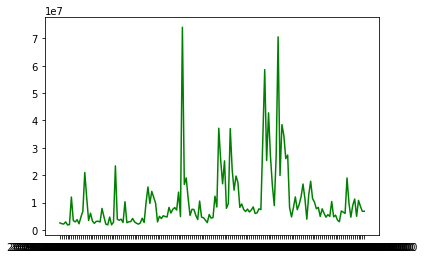

In [5]:
plt.plot(data['volumeto'][40:200],'g')

In [6]:
data.columns[1:7]

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close'], dtype='object')

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[1:7]].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [8]:
a = data[data.columns[1:7]]
a

,high,low,open,volumefrom,volumeto,close
timeUTC,,,,,,
2019-12-12 19:00:00,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14
2019-12-12 20:00:00,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79
2019-12-12 21:00:00,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97
2019-12-12 22:00:00,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38
2019-12-12 23:00:00,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50
...,...,...,...,...,...,...
2021-02-01 11:00:00,33847.46,33257.39,33450.01,2066.49,69445570.35,33675.45
2021-02-01 12:00:00,33779.76,33505.50,33675.45,1173.82,39473368.04,33590.20
2021-02-01 13:00:00,33945.41,33404.87,33590.20,1430.06,48159838.72,33576.82


In [9]:
b = a.values.reshape(-1,6)
b

array([[7.21993000e+03, 7.14915000e+03, 7.17018000e+03, 1.53679000e+03,
        1.10419948e+07, 7.16614000e+03],
       [7.20836000e+03, 7.16603000e+03, 7.16614000e+03, 7.85110000e+02,
        5.65460743e+06, 7.19979000e+03],
       [7.22243000e+03, 7.19487000e+03, 7.19979000e+03, 6.72460000e+02,
        4.85521322e+06, 7.19997000e+03],
       ...,
       [3.39454100e+04, 3.34048700e+04, 3.35902000e+04, 1.43006000e+03,
        4.81598387e+07, 3.35768200e+04],
       [3.39078900e+04, 3.34678700e+04, 3.35768200e+04, 1.19820000e+03,
        4.03194582e+07, 3.38030200e+04],
       [3.39506700e+04, 3.37396300e+04, 3.38030200e+04, 5.69390000e+02,
        1.92880552e+07, 3.38970600e+04]])

In [10]:
data.columns[1:7]

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close'], dtype='object')

In [11]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],values[train_size+val_size:,:]
print(len(train),len(val), len(test),len(test1))

8004 1000 1001 1001


In [12]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

7980
976
977
977


In [14]:
print(trainX.shape)
print(trainY.shape)

(7980, 24, 6)
(7980,)


In [15]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [16]:

X_train_min, X_train_max = trainX.min(axis=0), trainX.max(axis=0)
y_train_min, y_train_max = trainY.min(axis=0), trainY.max(axis=0)

In [17]:
trainX = (trainX - X_train_min)/(X_train_max - X_train_min+ 1e-9 )
valX= (valX - X_train_min)/(X_train_max - X_train_min+ 1e-9 )
testX = (testX - X_train_min)/(X_train_max - X_train_min+ 1e-9 )
trainY = (trainY - y_train_min)/(y_train_max - y_train_min + 1e-9)
valY = (valY - y_train_min)/(y_train_max - y_train_min+ 1e-9 )
testY = (testY - y_train_min)/(y_train_max - y_train_min+ 1e-9 )

In [18]:
trainX.shape

(7980, 24, 6)

## MTEX(1)

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
trainX = trainX.reshape(-1,24,6,1)
testX = testX.reshape(-1,24,6,1)
valX = valX.reshape(-1,24,6,1)

In [96]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_25 (Reshape)         (None, 24, 6)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
flatten_25 (Flatten)         (None, 1536)


Epoch 00035: val_loss did not improve from 0.00043
Epoch 36/200
80/80 [==============================] - 0s 4ms/step - loss: 3.6091e-05 - val_loss: 5.5416e-04

Epoch 00036: val_loss did not improve from 0.00043
Epoch 37/200
80/80 [==============================] - 0s 4ms/step - loss: 4.1093e-05 - val_loss: 8.3230e-04

Epoch 00037: val_loss did not improve from 0.00043
Epoch 38/200
80/80 [==============================] - 0s 4ms/step - loss: 4.6264e-05 - val_loss: 5.0402e-04

Epoch 00038: val_loss did not improve from 0.00043
Epoch 39/200
80/80 [==============================] - 0s 4ms/step - loss: 3.7879e-05 - val_loss: 5.5455e-04

Epoch 00039: val_loss did not improve from 0.00043
Epoch 40/200
80/80 [==============================] - 0s 4ms/step - loss: 3.8739e-05 - val_loss: 4.3079e-04

Epoch 00040: val_loss did not improve from 0.00043
Epoch 41/200
80/80 [==============================] - 0s 4ms/step - loss: 4.0617e-05 - val_loss: 5.0393e-04

Epoch 00041: val_loss did not improve f

80/80 [==============================] - 0s 4ms/step - loss: 3.3227e-05 - val_loss: 0.0032

Epoch 00139: val_loss did not improve from 0.00042
Epoch 140/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1263e-05 - val_loss: 0.0033

Epoch 00140: val_loss did not improve from 0.00042
Epoch 141/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0236e-05 - val_loss: 0.0041

Epoch 00141: val_loss did not improve from 0.00042
Epoch 142/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1616e-05 - val_loss: 0.0052

Epoch 00142: val_loss did not improve from 0.00042
Epoch 143/200
80/80 [==============================] - 0s 4ms/step - loss: 3.2131e-05 - val_loss: 0.0044

Epoch 00143: val_loss did not improve from 0.00042
Epoch 144/200
80/80 [==============================] - 0s 4ms/step - loss: 3.3707e-05 - val_loss: 0.0044

Epoch 00144: val_loss did not improve from 0.00042
Epoch 145/200
80/80 [==============================] - 0s 4ms/step - los

In [97]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(1).hdf5")

In [98]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.02143772
Test RMSE : 0.0752163956550646
Test MAE : 0.053553373
Test MSE : 0.005657506


## MTEX(2)

In [24]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 6)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            1216      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536) 

Epoch 37/200
80/80 [==============================] - 1s 7ms/step - loss: 4.8717e-05 - val_loss: 2.1182e-04

Epoch 00037: val_loss did not improve from 0.00020
Epoch 38/200
80/80 [==============================] - 1s 7ms/step - loss: 5.4242e-05 - val_loss: 2.1658e-04

Epoch 00038: val_loss did not improve from 0.00020
Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 4.8051e-05 - val_loss: 2.1873e-04

Epoch 00039: val_loss did not improve from 0.00020
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 6.1354e-05 - val_loss: 2.0074e-04

Epoch 00040: val_loss improved from 0.00020 to 0.00020, saving model to saved_weights/bitcoin_MTEX_onestep(2).hdf5
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 4.3258e-05 - val_loss: 2.4364e-04

Epoch 00041: val_loss did not improve from 0.00020
Epoch 42/200
80/80 [==============================] - 1s 7ms/step - loss: 6.0057e-05 - val_loss: 3.8221e-04

Epoch 00042: val_loss did n

80/80 [==============================] - 1s 7ms/step - loss: 3.1299e-05 - val_loss: 3.9612e-04

Epoch 00135: val_loss did not improve from 0.00016
Epoch 136/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9514e-05 - val_loss: 4.2144e-04

Epoch 00136: val_loss did not improve from 0.00016
Epoch 137/200
80/80 [==============================] - 1s 7ms/step - loss: 3.5180e-05 - val_loss: 1.9450e-04

Epoch 00137: val_loss did not improve from 0.00016
Epoch 138/200
80/80 [==============================] - 1s 7ms/step - loss: 4.7531e-05 - val_loss: 4.2833e-04

Epoch 00138: val_loss did not improve from 0.00016
Epoch 139/200
80/80 [==============================] - 1s 7ms/step - loss: 3.8613e-05 - val_loss: 3.7125e-04

Epoch 00139: val_loss did not improve from 0.00016
Epoch 140/200
80/80 [==============================] - 1s 7ms/step - loss: 3.5365e-05 - val_loss: 2.6928e-04

Epoch 00140: val_loss did not improve from 0.00016
Epoch 141/200
80/80 [===========================

In [25]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(2).hdf5")

In [26]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.011665503
Test RMSE : 0.041703603467075995
Test MAE : 0.029089898
Test MSE : 0.0017391905


## MTEX(3)

In [54]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_11 (Reshape)         (None, 24, 6)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
flatten_11 (Flatten)         (None, 1536)

Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 3.7407e-05 - val_loss: 2.4171e-04

Epoch 00039: val_loss did not improve from 0.00022
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 4.6610e-05 - val_loss: 2.6613e-04

Epoch 00040: val_loss did not improve from 0.00022
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 4.5743e-05 - val_loss: 2.7303e-04

Epoch 00041: val_loss did not improve from 0.00022
Epoch 42/200
80/80 [==============================] - 1s 7ms/step - loss: 4.3046e-05 - val_loss: 3.6744e-04

Epoch 00042: val_loss did not improve from 0.00022
Epoch 43/200
80/80 [==============================] - 1s 7ms/step - loss: 4.0837e-05 - val_loss: 2.3785e-04

Epoch 00043: val_loss did not improve from 0.00022
Epoch 44/200
80/80 [==============================] - 1s 7ms/step - loss: 3.6389e-05 - val_loss: 4.3698e-04

Epoch 00044: val_loss did not improve from 0.00022
Epoch 45/200
80/80 [====================

80/80 [==============================] - 1s 7ms/step - loss: 3.3239e-05 - val_loss: 1.6766e-04

Epoch 00087: val_loss did not improve from 0.00016
Epoch 88/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9320e-05 - val_loss: 1.5674e-04

Epoch 00088: val_loss improved from 0.00016 to 0.00016, saving model to saved_weights/bitcoin_MTEX_onestep(3).hdf5
Epoch 89/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0440e-05 - val_loss: 1.6767e-04

Epoch 00089: val_loss did not improve from 0.00016
Epoch 90/200
80/80 [==============================] - 1s 7ms/step - loss: 3.5100e-05 - val_loss: 1.9158e-04

Epoch 00090: val_loss did not improve from 0.00016
Epoch 91/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1844e-05 - val_loss: 1.8156e-04

Epoch 00091: val_loss did not improve from 0.00016
Epoch 92/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2000e-05 - val_loss: 2.2945e-04

Epoch 00092: val_loss did not improve fr

80/80 [==============================] - 1s 7ms/step - loss: 2.9354e-05 - val_loss: 1.9027e-04

Epoch 00188: val_loss did not improve from 0.00016
Epoch 189/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1730e-05 - val_loss: 1.6771e-04

Epoch 00189: val_loss did not improve from 0.00016
Epoch 190/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1527e-05 - val_loss: 1.6936e-04

Epoch 00190: val_loss did not improve from 0.00016
Epoch 191/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4930e-05 - val_loss: 2.1689e-04

Epoch 00191: val_loss did not improve from 0.00016
Epoch 192/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9737e-05 - val_loss: 2.4562e-04

Epoch 00192: val_loss did not improve from 0.00016
Epoch 193/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0526e-05 - val_loss: 2.9629e-04

Epoch 00193: val_loss did not improve from 0.00016
Epoch 194/200
80/80 [===========================

In [55]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(3).hdf5")

In [56]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.014790596
Test RMSE : 0.056570134612526676
Test MAE : 0.037197143
Test MSE : 0.0032001801


## MTEX(4)

In [57]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_12 (Reshape)         (None, 24, 6)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
flatten_12 (Flatten)         (None, 1536)


Epoch 00037: val_loss improved from 0.00022 to 0.00021, saving model to saved_weights/bitcoin_MTEX_onestep(4).hdf5
Epoch 38/200
80/80 [==============================] - 1s 7ms/step - loss: 4.9888e-05 - val_loss: 2.8579e-04

Epoch 00038: val_loss did not improve from 0.00021
Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 4.8459e-05 - val_loss: 3.0546e-04

Epoch 00039: val_loss did not improve from 0.00021
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 5.2075e-05 - val_loss: 0.0010

Epoch 00040: val_loss did not improve from 0.00021
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 7.0275e-05 - val_loss: 0.0012

Epoch 00041: val_loss did not improve from 0.00021
Epoch 42/200
80/80 [==============================] - 1s 7ms/step - loss: 6.4163e-05 - val_loss: 2.1151e-04

Epoch 00042: val_loss did not improve from 0.00021
Epoch 43/200
80/80 [==============================] - 1s 7ms/step - loss: 5.5146e-05 - val_l

80/80 [==============================] - 1s 7ms/step - loss: 4.0144e-05 - val_loss: 2.5946e-04

Epoch 00087: val_loss did not improve from 0.00019
Epoch 88/200
80/80 [==============================] - 1s 7ms/step - loss: 4.3263e-05 - val_loss: 3.7572e-04

Epoch 00088: val_loss did not improve from 0.00019
Epoch 89/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4011e-05 - val_loss: 2.7164e-04

Epoch 00089: val_loss did not improve from 0.00019
Epoch 90/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4699e-05 - val_loss: 2.2379e-04

Epoch 00090: val_loss did not improve from 0.00019
Epoch 91/200
80/80 [==============================] - 1s 7ms/step - loss: 3.7188e-05 - val_loss: 1.8225e-04

Epoch 00091: val_loss improved from 0.00019 to 0.00018, saving model to saved_weights/bitcoin_MTEX_onestep(4).hdf5
Epoch 92/200
80/80 [==============================] - 1s 7ms/step - loss: 4.1962e-05 - val_loss: 3.6710e-04

Epoch 00092: val_loss did not improve fr

80/80 [==============================] - 1s 7ms/step - loss: 2.9841e-05 - val_loss: 2.3400e-04

Epoch 00187: val_loss did not improve from 0.00017
Epoch 188/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0200e-05 - val_loss: 4.2070e-04

Epoch 00188: val_loss did not improve from 0.00017
Epoch 189/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4062e-05 - val_loss: 2.0202e-04

Epoch 00189: val_loss did not improve from 0.00017
Epoch 190/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0898e-05 - val_loss: 3.5161e-04

Epoch 00190: val_loss did not improve from 0.00017
Epoch 191/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9340e-05 - val_loss: 6.7798e-04

Epoch 00191: val_loss did not improve from 0.00017
Epoch 192/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0878e-05 - val_loss: 5.4699e-04

Epoch 00192: val_loss did not improve from 0.00017
Epoch 193/200
80/80 [===========================

In [58]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(4).hdf5")

In [59]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.017056068
Test RMSE : 0.06182948127882918
Test MAE : 0.042785965
Test MSE : 0.0038228848


## MTEX(5)

In [33]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_4 (Reshape)          (None, 24, 6)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 64)            1216      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536) 

80/80 [==============================] - 1s 7ms/step - loss: 3.1563e-05 - val_loss: 4.1105e-04

Epoch 00087: val_loss did not improve from 0.00024
Epoch 88/200
80/80 [==============================] - 1s 7ms/step - loss: 5.9790e-05 - val_loss: 6.4732e-04

Epoch 00088: val_loss did not improve from 0.00024
Epoch 89/200
80/80 [==============================] - 1s 7ms/step - loss: 4.4920e-05 - val_loss: 5.5864e-04

Epoch 00089: val_loss did not improve from 0.00024
Epoch 90/200
80/80 [==============================] - 1s 7ms/step - loss: 4.1932e-05 - val_loss: 8.3449e-04

Epoch 00090: val_loss did not improve from 0.00024
Epoch 91/200
80/80 [==============================] - 1s 7ms/step - loss: 4.2340e-05 - val_loss: 4.7301e-04

Epoch 00091: val_loss did not improve from 0.00024
Epoch 92/200
80/80 [==============================] - 1s 7ms/step - loss: 3.7445e-05 - val_loss: 4.9619e-04

Epoch 00092: val_loss did not improve from 0.00024
Epoch 93/200
80/80 [==============================] -

80/80 [==============================] - 1s 7ms/step - loss: 2.8881e-05 - val_loss: 3.4656e-04

Epoch 00187: val_loss did not improve from 0.00018
Epoch 188/200
80/80 [==============================] - 1s 7ms/step - loss: 2.8350e-05 - val_loss: 3.7354e-04

Epoch 00188: val_loss did not improve from 0.00018
Epoch 189/200
80/80 [==============================] - 1s 7ms/step - loss: 3.3727e-05 - val_loss: 2.8470e-04

Epoch 00189: val_loss did not improve from 0.00018
Epoch 190/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9259e-05 - val_loss: 2.9165e-04

Epoch 00190: val_loss did not improve from 0.00018
Epoch 191/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9712e-05 - val_loss: 2.3437e-04

Epoch 00191: val_loss did not improve from 0.00018
Epoch 192/200
80/80 [==============================] - 1s 7ms/step - loss: 2.7295e-05 - val_loss: 1.9360e-04

Epoch 00192: val_loss did not improve from 0.00018
Epoch 193/200
80/80 [===========================

In [34]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(5).hdf5")

In [35]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.01753214
Test RMSE : 0.0642410278139096
Test MAE : 0.04446249
Test MSE : 0.0041269097


## MTEX(6)

In [36]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_5 (Reshape)          (None, 24, 6)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)            1216      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536) 

Epoch 38/200
80/80 [==============================] - 1s 7ms/step - loss: 1.4020e-04 - val_loss: 8.8410e-04

Epoch 00038: val_loss did not improve from 0.00038
Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 5.7551e-05 - val_loss: 4.3729e-04

Epoch 00039: val_loss did not improve from 0.00038
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 4.8374e-05 - val_loss: 3.9623e-04

Epoch 00040: val_loss did not improve from 0.00038
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 5.8952e-05 - val_loss: 8.9807e-04

Epoch 00041: val_loss did not improve from 0.00038
Epoch 42/200
80/80 [==============================] - 1s 7ms/step - loss: 5.4751e-05 - val_loss: 4.7991e-04

Epoch 00042: val_loss did not improve from 0.00038
Epoch 43/200
80/80 [==============================] - 1s 7ms/step - loss: 7.4906e-05 - val_loss: 6.5227e-04

Epoch 00043: val_loss did not improve from 0.00038
Epoch 44/200
80/80 [====================


Epoch 00139: val_loss did not improve from 0.00030
Epoch 140/200
80/80 [==============================] - 0s 4ms/step - loss: 3.3833e-05 - val_loss: 6.4750e-04

Epoch 00140: val_loss did not improve from 0.00030
Epoch 141/200
80/80 [==============================] - 0s 4ms/step - loss: 2.9143e-05 - val_loss: 5.1503e-04

Epoch 00141: val_loss did not improve from 0.00030
Epoch 142/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1349e-05 - val_loss: 7.3498e-04

Epoch 00142: val_loss did not improve from 0.00030
Epoch 143/200
80/80 [==============================] - 0s 4ms/step - loss: 2.9704e-05 - val_loss: 0.0016

Epoch 00143: val_loss did not improve from 0.00030
Epoch 144/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1613e-05 - val_loss: 5.6847e-04

Epoch 00144: val_loss did not improve from 0.00030
Epoch 145/200
80/80 [==============================] - 0s 4ms/step - loss: 2.8686e-05 - val_loss: 6.9260e-04

Epoch 00145: val_loss did not improve


Epoch 00190: val_loss did not improve from 0.00030
Epoch 191/200
80/80 [==============================] - 0s 4ms/step - loss: 3.2538e-05 - val_loss: 0.0012

Epoch 00191: val_loss did not improve from 0.00030
Epoch 192/200
80/80 [==============================] - 0s 4ms/step - loss: 3.7863e-05 - val_loss: 5.1613e-04

Epoch 00192: val_loss did not improve from 0.00030
Epoch 193/200
80/80 [==============================] - 0s 4ms/step - loss: 2.6852e-05 - val_loss: 0.0013

Epoch 00193: val_loss did not improve from 0.00030
Epoch 194/200
80/80 [==============================] - 0s 4ms/step - loss: 4.3174e-05 - val_loss: 8.6052e-04

Epoch 00194: val_loss did not improve from 0.00030
Epoch 195/200
80/80 [==============================] - 0s 4ms/step - loss: 3.4267e-05 - val_loss: 7.9232e-04

Epoch 00195: val_loss did not improve from 0.00030
Epoch 196/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1752e-05 - val_loss: 7.8917e-04

Epoch 00196: val_loss did not improve fro

In [37]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(6).hdf5")

In [38]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.016223548
Test RMSE : 0.05872036446417071
Test MAE : 0.04081203
Test MSE : 0.0034480812


## MTEX(7)

In [39]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_6 (Reshape)          (None, 24, 6)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 64)            1216      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1536) 

80/80 [==============================] - 0s 4ms/step - loss: 3.9014e-05 - val_loss: 4.9659e-04

Epoch 00037: val_loss did not improve from 0.00032
Epoch 38/200
80/80 [==============================] - 0s 4ms/step - loss: 3.5704e-05 - val_loss: 3.1361e-04

Epoch 00038: val_loss improved from 0.00032 to 0.00031, saving model to saved_weights/bitcoin_MTEX_onestep(7).hdf5
Epoch 39/200
80/80 [==============================] - 0s 4ms/step - loss: 3.6740e-05 - val_loss: 2.7754e-04

Epoch 00039: val_loss improved from 0.00031 to 0.00028, saving model to saved_weights/bitcoin_MTEX_onestep(7).hdf5
Epoch 40/200
80/80 [==============================] - 0s 4ms/step - loss: 4.1971e-05 - val_loss: 7.0366e-04

Epoch 00040: val_loss did not improve from 0.00028
Epoch 41/200
80/80 [==============================] - 0s 4ms/step - loss: 4.4201e-05 - val_loss: 2.9295e-04

Epoch 00041: val_loss did not improve from 0.00028
Epoch 42/200
80/80 [==============================] - 0s 4ms/step - loss: 4.6074e-05 

80/80 [==============================] - 0s 4ms/step - loss: 2.9680e-05 - val_loss: 5.1375e-04

Epoch 00087: val_loss did not improve from 0.00024
Epoch 88/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1589e-05 - val_loss: 0.0012

Epoch 00088: val_loss did not improve from 0.00024
Epoch 89/200
80/80 [==============================] - 0s 4ms/step - loss: 3.4041e-05 - val_loss: 3.5608e-04

Epoch 00089: val_loss did not improve from 0.00024
Epoch 90/200
80/80 [==============================] - 0s 4ms/step - loss: 3.9348e-05 - val_loss: 5.5797e-04

Epoch 00090: val_loss did not improve from 0.00024
Epoch 91/200
80/80 [==============================] - 0s 4ms/step - loss: 3.6966e-05 - val_loss: 6.0750e-04

Epoch 00091: val_loss did not improve from 0.00024
Epoch 92/200
80/80 [==============================] - 0s 4ms/step - loss: 4.0598e-05 - val_loss: 7.4733e-04

Epoch 00092: val_loss did not improve from 0.00024
Epoch 93/200
80/80 [==============================] - 0s 

80/80 [==============================] - 0s 4ms/step - loss: 2.8651e-05 - val_loss: 1.9650e-04

Epoch 00136: val_loss did not improve from 0.00017
Epoch 137/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0068e-05 - val_loss: 2.7638e-04

Epoch 00137: val_loss did not improve from 0.00017
Epoch 138/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0853e-05 - val_loss: 2.4878e-04

Epoch 00138: val_loss did not improve from 0.00017
Epoch 139/200
80/80 [==============================] - 0s 4ms/step - loss: 3.5427e-05 - val_loss: 2.9376e-04

Epoch 00139: val_loss did not improve from 0.00017
Epoch 140/200
80/80 [==============================] - 0s 4ms/step - loss: 3.1214e-05 - val_loss: 4.8543e-04

Epoch 00140: val_loss did not improve from 0.00017
Epoch 141/200
80/80 [==============================] - 0s 4ms/step - loss: 3.3651e-05 - val_loss: 1.9357e-04

Epoch 00141: val_loss did not improve from 0.00017
Epoch 142/200
80/80 [===========================

In [40]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(7).hdf5")

In [41]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.02007041
Test RMSE : 0.09740856231120855
Test MAE : 0.049821652
Test MSE : 0.009488428


## MTEX(8)

In [60]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_13 (Reshape)         (None, 24, 6)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
flatten_13 (Flatten)         (None, 1536)

Epoch 36/200
80/80 [==============================] - 1s 7ms/step - loss: 4.2079e-05 - val_loss: 2.3034e-04

Epoch 00036: val_loss did not improve from 0.00020
Epoch 37/200
80/80 [==============================] - 1s 7ms/step - loss: 5.9698e-05 - val_loss: 2.5690e-04

Epoch 00037: val_loss did not improve from 0.00020
Epoch 38/200
80/80 [==============================] - 1s 7ms/step - loss: 4.2927e-05 - val_loss: 2.7494e-04

Epoch 00038: val_loss did not improve from 0.00020
Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 3.9479e-05 - val_loss: 1.9681e-04

Epoch 00039: val_loss improved from 0.00020 to 0.00020, saving model to saved_weights/bitcoin_MTEX_onestep(8).hdf5
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 3.8358e-05 - val_loss: 2.0466e-04

Epoch 00040: val_loss did not improve from 0.00020
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 4.0938e-05 - val_loss: 2.2471e-04

Epoch 00041: val_loss did n

80/80 [==============================] - 1s 7ms/step - loss: 4.3213e-05 - val_loss: 3.5094e-04

Epoch 00084: val_loss did not improve from 0.00016
Epoch 85/200
80/80 [==============================] - 1s 7ms/step - loss: 6.5090e-05 - val_loss: 1.5617e-04

Epoch 00085: val_loss improved from 0.00016 to 0.00016, saving model to saved_weights/bitcoin_MTEX_onestep(8).hdf5
Epoch 86/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2223e-05 - val_loss: 2.6401e-04

Epoch 00086: val_loss did not improve from 0.00016
Epoch 87/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1005e-05 - val_loss: 1.5541e-04

Epoch 00087: val_loss improved from 0.00016 to 0.00016, saving model to saved_weights/bitcoin_MTEX_onestep(8).hdf5
Epoch 88/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4616e-05 - val_loss: 2.5902e-04

Epoch 00088: val_loss did not improve from 0.00016
Epoch 89/200
80/80 [==============================] - 1s 7ms/step - loss: 3.4186e-05 

80/80 [==============================] - 1s 7ms/step - loss: 3.2579e-05 - val_loss: 2.4532e-04

Epoch 00134: val_loss did not improve from 0.00016
Epoch 135/200
80/80 [==============================] - 1s 7ms/step - loss: 2.8523e-05 - val_loss: 2.3034e-04

Epoch 00135: val_loss did not improve from 0.00016
Epoch 136/200
80/80 [==============================] - 1s 7ms/step - loss: 3.3732e-05 - val_loss: 1.8365e-04

Epoch 00136: val_loss did not improve from 0.00016
Epoch 137/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1459e-05 - val_loss: 1.7911e-04

Epoch 00137: val_loss did not improve from 0.00016
Epoch 138/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2844e-05 - val_loss: 1.7011e-04

Epoch 00138: val_loss did not improve from 0.00016
Epoch 139/200
80/80 [==============================] - 1s 7ms/step - loss: 3.5856e-05 - val_loss: 2.0373e-04

Epoch 00139: val_loss did not improve from 0.00016
Epoch 140/200
80/80 [===========================

80/80 [==============================] - 1s 7ms/step - loss: 3.0503e-05 - val_loss: 1.6220e-04

Epoch 00185: val_loss did not improve from 0.00016
Epoch 186/200
80/80 [==============================] - 1s 7ms/step - loss: 2.7016e-05 - val_loss: 1.7425e-04

Epoch 00186: val_loss did not improve from 0.00016
Epoch 187/200
80/80 [==============================] - 1s 7ms/step - loss: 3.3708e-05 - val_loss: 1.9231e-04

Epoch 00187: val_loss did not improve from 0.00016
Epoch 188/200
80/80 [==============================] - 1s 7ms/step - loss: 3.3149e-05 - val_loss: 1.6865e-04

Epoch 00188: val_loss did not improve from 0.00016
Epoch 189/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1048e-05 - val_loss: 1.7454e-04

Epoch 00189: val_loss did not improve from 0.00016
Epoch 190/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2401e-05 - val_loss: 2.6992e-04

Epoch 00190: val_loss did not improve from 0.00016
Epoch 191/200
80/80 [===========================

In [61]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(8).hdf5")

In [62]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.015750796
Test RMSE : 0.07645098888333508
Test MAE : 0.03909906
Test MSE : 0.0058447537


## MTEX(9)

In [78]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_19 (Reshape)         (None, 24, 6)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
flatten_19 (Flatten)         (None, 1536)

80/80 [==============================] - 0s 4ms/step - loss: 4.1192e-05 - val_loss: 5.9874e-04

Epoch 00085: val_loss did not improve from 0.00042
Epoch 86/200
80/80 [==============================] - 0s 4ms/step - loss: 4.5336e-05 - val_loss: 0.0011

Epoch 00086: val_loss did not improve from 0.00042
Epoch 87/200
80/80 [==============================] - 0s 4ms/step - loss: 4.5651e-05 - val_loss: 7.3822e-04

Epoch 00087: val_loss did not improve from 0.00042
Epoch 88/200
80/80 [==============================] - 0s 4ms/step - loss: 3.9071e-05 - val_loss: 2.8948e-04

Epoch 00088: val_loss improved from 0.00042 to 0.00029, saving model to saved_weights/bitcoin_MTEX_onestep(9).hdf5
Epoch 89/200
80/80 [==============================] - 0s 4ms/step - loss: 4.7755e-05 - val_loss: 3.6736e-04

Epoch 00089: val_loss did not improve from 0.00029
Epoch 90/200
80/80 [==============================] - 0s 4ms/step - loss: 3.9186e-05 - val_loss: 5.2464e-04

Epoch 00090: val_loss did not improve from 0


Epoch 00135: val_loss improved from 0.00028 to 0.00026, saving model to saved_weights/bitcoin_MTEX_onestep(9).hdf5
Epoch 136/200
80/80 [==============================] - 0s 4ms/step - loss: 3.4777e-05 - val_loss: 4.8934e-04

Epoch 00136: val_loss did not improve from 0.00026
Epoch 137/200
80/80 [==============================] - 0s 4ms/step - loss: 3.2613e-05 - val_loss: 4.9248e-04

Epoch 00137: val_loss did not improve from 0.00026
Epoch 138/200
80/80 [==============================] - 0s 4ms/step - loss: 4.0833e-05 - val_loss: 6.4096e-04

Epoch 00138: val_loss did not improve from 0.00026
Epoch 139/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0460e-05 - val_loss: 6.9721e-04

Epoch 00139: val_loss did not improve from 0.00026
Epoch 140/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0112e-05 - val_loss: 4.6961e-04

Epoch 00140: val_loss did not improve from 0.00026
Epoch 141/200
80/80 [==============================] - 0s 4ms/step - loss: 4.14

80/80 [==============================] - 0s 4ms/step - loss: 2.8210e-05 - val_loss: 0.0012

Epoch 00186: val_loss did not improve from 0.00020
Epoch 187/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0183e-05 - val_loss: 5.0489e-04

Epoch 00187: val_loss did not improve from 0.00020
Epoch 188/200
80/80 [==============================] - 0s 4ms/step - loss: 2.9814e-05 - val_loss: 4.2126e-04

Epoch 00188: val_loss did not improve from 0.00020
Epoch 189/200
80/80 [==============================] - 0s 4ms/step - loss: 2.8129e-05 - val_loss: 3.2872e-04

Epoch 00189: val_loss did not improve from 0.00020
Epoch 190/200
80/80 [==============================] - 0s 4ms/step - loss: 4.1139e-05 - val_loss: 6.5898e-04

Epoch 00190: val_loss did not improve from 0.00020
Epoch 191/200
80/80 [==============================] - 0s 4ms/step - loss: 3.0054e-05 - val_loss: 9.5957e-04

Epoch 00191: val_loss did not improve from 0.00020
Epoch 192/200
80/80 [==============================]

In [79]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(9).hdf5")

In [80]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.021348638
Test RMSE : 0.06990010799148408
Test MAE : 0.05381504
Test MSE : 0.004886025


## MTEX(10)

In [48]:
first_input = Input(shape=(24,6,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,6,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,6))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bitcoin_MTEX_onestep(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 6, 1)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 6, 1)]        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 6, 16)         144       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 6, 32)         2080      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 6, 1)          33        
_________________________________________________________________
reshape_9 (Reshape)          (None, 24, 6)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            1216      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1536) 


Epoch 00036: val_loss did not improve from 0.00052
Epoch 37/200
80/80 [==============================] - 1s 7ms/step - loss: 6.2358e-05 - val_loss: 7.5901e-04

Epoch 00037: val_loss did not improve from 0.00052
Epoch 38/200
80/80 [==============================] - 1s 7ms/step - loss: 5.2190e-05 - val_loss: 5.6399e-04

Epoch 00038: val_loss did not improve from 0.00052
Epoch 39/200
80/80 [==============================] - 1s 7ms/step - loss: 4.4633e-05 - val_loss: 4.4824e-04

Epoch 00039: val_loss improved from 0.00052 to 0.00045, saving model to saved_weights/bitcoin_MTEX_onestep(10).hdf5
Epoch 40/200
80/80 [==============================] - 1s 7ms/step - loss: 5.0038e-05 - val_loss: 6.0667e-04

Epoch 00040: val_loss did not improve from 0.00045
Epoch 41/200
80/80 [==============================] - 1s 7ms/step - loss: 4.3768e-05 - val_loss: 4.5122e-04

Epoch 00041: val_loss did not improve from 0.00045
Epoch 42/200
80/80 [==============================] - 1s 8ms/step - loss: 4.3151e-0

80/80 [==============================] - 1s 7ms/step - loss: 4.0834e-05 - val_loss: 6.1898e-04

Epoch 00134: val_loss did not improve from 0.00027
Epoch 135/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0151e-05 - val_loss: 3.1269e-04

Epoch 00135: val_loss did not improve from 0.00027
Epoch 136/200
80/80 [==============================] - 1s 7ms/step - loss: 4.6996e-05 - val_loss: 0.0016

Epoch 00136: val_loss did not improve from 0.00027
Epoch 137/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2445e-05 - val_loss: 0.0016

Epoch 00137: val_loss did not improve from 0.00027
Epoch 138/200
80/80 [==============================] - 1s 7ms/step - loss: 3.2346e-05 - val_loss: 8.8645e-04

Epoch 00138: val_loss did not improve from 0.00027
Epoch 139/200
80/80 [==============================] - 1s 7ms/step - loss: 3.9866e-05 - val_loss: 8.7249e-04

Epoch 00139: val_loss did not improve from 0.00027
Epoch 140/200
80/80 [==============================] - 1

80/80 [==============================] - 1s 7ms/step - loss: 3.2037e-05 - val_loss: 0.0019

Epoch 00186: val_loss did not improve from 0.00027
Epoch 187/200
80/80 [==============================] - 1s 7ms/step - loss: 3.1417e-05 - val_loss: 0.0013

Epoch 00187: val_loss did not improve from 0.00027
Epoch 188/200
80/80 [==============================] - 1s 7ms/step - loss: 4.9137e-05 - val_loss: 0.0025

Epoch 00188: val_loss did not improve from 0.00027
Epoch 189/200
80/80 [==============================] - 1s 7ms/step - loss: 3.0484e-05 - val_loss: 7.1460e-04

Epoch 00189: val_loss did not improve from 0.00027
Epoch 190/200
80/80 [==============================] - 1s 7ms/step - loss: 2.7513e-05 - val_loss: 0.0012

Epoch 00190: val_loss did not improve from 0.00027
Epoch 191/200
80/80 [==============================] - 1s 7ms/step - loss: 2.9357e-05 - val_loss: 0.0023

Epoch 00191: val_loss did not improve from 0.00027
Epoch 192/200
80/80 [==============================] - 1s 6ms/step -

In [49]:
model.load_weights("saved_weights/bitcoin_MTEX_onestep(10).hdf5")

In [50]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.016643522
Test RMSE : 0.05927973959227297
Test MAE : 0.041648235
Test MSE : 0.0035140875


In [ ]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])